In [1]:
image_size = 512
backbone='efficientdetv2_ds'
checkpoint='sagittal_detection_effdet_112841-epoch-24'

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms

# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'train_sagittal_images_jpeg95')

In [4]:
boundary_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_sagittal_boundary.csv')).set_index('UID')
print(len(boundary_df))
boundary_df.head()

2012


,Unnamed: 0,height,width,xmin,ymin,xmax,ymax
UID,,,,,,,
1.2.826.0.1.3680043.10001,0,659,512,47.024193,71.835014,420.97748,620.1517
1.2.826.0.1.3680043.10005,1,541,512,63.075333,10.491298,460.40836,411.9475
1.2.826.0.1.3680043.10014,2,882,512,11.231842,91.550030,506.54834,843.6671
1.2.826.0.1.3680043.10016,3,733,512,27.175400,41.369190,438.84436,631.6106
1.2.826.0.1.3680043.10032,4,626,512,30.145882,57.993862,443.24400,604.6150


In [5]:
def square_crop_position(crop_box, image_size=512):
    """
    crop box 를 정방형으로 만들어준다.
    :param left:
    :param top:
    :param right:
    :param bottom:
    :param image_size:
    :return:
    """
    left, top, right, bottom = crop_box
    w, h = right - left, bottom - top

    if h > w:
        left_pad = (h - w) // 2
        right_pad = h - w - left_pad
        left -= left_pad
        right += right_pad

        if left < 0:
            right -= left
            left = 0
        elif right > image_size:
            left -= right - image_size
            right = image_size
    else:
        top_pad = (w - h) // 2
        bottom_pad = w - h - top_pad
        top -= top_pad
        bottom += bottom_pad

        if top < 0:
            bottom -= top
            top = 0
        elif bottom > image_size:
            top -= bottom - image_size
            bottom = image_size
    return left, top, right, bottom


square_crop_position([0, 1, 2, 4], image_size=5)

(0, 1, 3, 4)

In [6]:
for i in range(len(boundary_df)):
    boundary = boundary_df.iloc[i]
    boundary_df.loc[boundary.name, ['xmin','ymin','xmax','ymax']] = square_crop_position(boundary[['xmin','ymin','xmax','ymax']].values, image_size)
print(len(boundary_df))
boundary_df.head()

2012


,Unnamed: 0,height,width,xmin,ymin,xmax,ymax
UID,,,,,,,
1.2.826.0.1.3680043.10001,0,659,512,0.000000,71.835014,548.316686,620.1517
1.2.826.0.1.3680043.10005,1,541,512,61.075333,10.491298,462.531535,411.9475
1.2.826.0.1.3680043.10014,2,882,512,0.000000,91.550030,752.117070,843.6671
1.2.826.0.1.3680043.10016,3,733,512,0.000000,41.369190,590.241410,631.6106
1.2.826.0.1.3680043.10032,4,626,512,0.000000,57.993862,546.621138,604.6150


In [7]:
def get_image_and_labels_by_idx(image_dir, boundary_df, UID, slice):

    r = Image.open(os.path.join(image_dir, UID, f"{slice - 1}.jpeg"))
    g = Image.open(os.path.join(image_dir, UID, f"{slice - 0}.jpeg"))
    b = Image.open(os.path.join(image_dir, UID, f"{slice + 1}.jpeg"))
    img = Image.merge('RGB', (r, g, b))

    s = boundary_df.loc[UID]

    crop_box = s[['xmin', 'ymin', 'xmax', 'ymax']].values
    return img, crop_box

In [8]:
def get_valid_transforms(target_img_size=512):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize(0.5, 0.5),
            ToTensorV2(p=1),
        ]
    )
transform = get_valid_transforms()


## Model

In [9]:
from effdet import create_model
model = create_model(backbone , bench_task='predict' , num_classes= 1 , image_size=(image_size, image_size), bench_labeler=True, pretrained=True)
model = model.to(device)
mdoel = model.eval()

In [10]:
state = torch.load(os.path.join(DATA_DIR, 'checkpoint',f'{checkpoint}.pth'))
model.load_state_dict(state["model"])

<All keys matched successfully>

[tensor([8.3548e+00, 5.6785e+01, 2.6102e+02, 1.2548e+02, 1.8784e-01],
       device='cuda:0')]


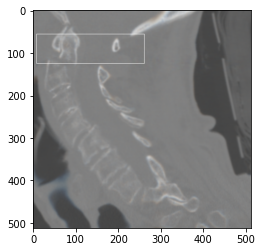

In [19]:
from torchvision.utils import draw_bounding_boxes
def infer_slice(UID, slice):
    image, crop_box = get_image_and_labels_by_idx(IMAGES_DIR, boundary_df, UID, slice)
    image = image.crop(crop_box)
    transformed = transform(image=np.array(image, dtype=np.float32))
    image = transformed["image"]

    bboxes = model(image.to(device).unsqueeze(0))[0]

    image = (image * 0.5 + 0.5) * 255
    image = image.to(torch.uint8)
    print(list(bboxes[:1, :5]))
    bbox_image = draw_bounding_boxes(image, boxes=bboxes[:1, :4], colors='white')
    plt.imshow(bbox_image.permute(1, 2, 0).cpu().numpy(), cmap='bone')

with torch.no_grad():
    model.eval()
    infer_slice('1.2.826.0.1.3680043.575', 338)

100%|██████████| 94/94 [00:13<00:00,  6.88it/s]


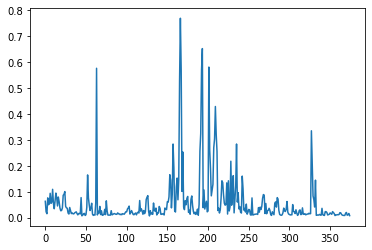

166


In [44]:
infer_result = []

def read_batch_image(UID, slice, batch_size):
    image_list = []
    for i in range(batch_size):
        image, crop_box = get_image_and_labels_by_idx(IMAGES_DIR, boundary_df, UID, slice + i)
        image = image.crop(crop_box)
        transformed = transform(image=np.array(image, dtype=np.float32))
        image = transformed["image"]
        image_list.append(image)
    return torch.stack(image_list, dim=0)

def infer_patient_axial(UID):
    image_paths = glob.glob(os.path.join(IMAGES_DIR, UID) + '/*.jpeg')

    slice = 1
    end_slice = len(image_paths) - 2

    batch_size = 4

    bboxes_list = []

    for i in tqdm(range(math.ceil((end_slice-1) / batch_size))):
        batch_size = min(end_slice - slice, batch_size)
        images = read_batch_image(UID, slice, batch_size)
        images = images.to(device)
        bboxes = model(images)

        bboxes_list.extend(bboxes[:, 0, :5].cpu().numpy())
        slice += batch_size

    return np.array(bboxes_list)

with torch.no_grad():
    model.eval()
    bboxes_list = infer_patient_axial('1.2.826.0.1.3680043.14345')
    plt.plot(bboxes_list[:, 4])
    plt.show()
    print(np.argmax(bboxes_list[:, 4]))

In [13]:
# plt.show()

In [14]:
# bboxes_list

In [15]:
# bboxes_list[96:105]

In [16]:
# plt.plot(bboxes_list)